# Quantum Pulsar

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
from generate_toy_pulsar_data import generate_fake_data
print("Imports Successful")

Imports Successful


In [3]:
nchan, ntime = 64, 64
period_real = 6.4
dm_real = 20.
noise_frac = 0.0

data = generate_fake_data(nchan, ntime, period_real, dm_real, noise_frac)

(64, 64)


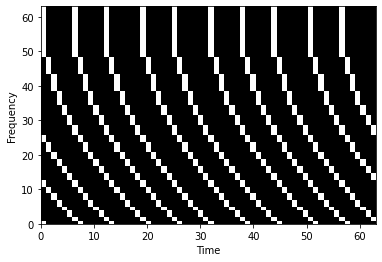

In [4]:
fig, ax = plt.subplots()
ax.imshow(data, vmin=0, vmax=1, origin='lower', aspect='auto',
          cmap='gray', extent=[0, ntime-1, 0, nchan-1])
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
fig.savefig("raw-data.svg")
print(data.shape)

## Boolean Oracle to encode the data

We are trying to encode the data as a boolean oracle of the type :

$$ |x\rangle|0\rangle \rightarrow |x\rangle |f(x,\tau) \rangle $$

where the first register encodes the time value in binary form and the second register the value of the data at that time for a given value of the lag $\tau$.

We can also think of using more than two register as :

$$ |x\rangle|0\rangle ... |0\rangle \rightarrow |x\rangle |f(x,\tau_0) \rangle ... |f(x,\tau_k) \rangle  $$

## Creating the operator

We create that oracle using a register of nbits encoding the $x$ values and a single qbit register to encode the value of the function $f(x,\tau)$

In [11]:
from qiskit.quantum_info.operators import Operator

def BooleanOracle(data, lag):
    
    # number of time points
    npts = data.shape[0]
    
    # number of qbits needed to encode npts
    # this is the size of the first register
    nqbits = int(np.log2(npts))
    
    # total size of the binary words
    size = 2**(nqbits+1)
    
    # create the operator matrix
    M = np.eye(size,size)
    
    #get the index of the points where the data is 1.
    idx = np.argwhere(data[lag]==1).flatten()
    
    # swap the bits 
    for i in idx:
        M[i,i] = 0
        M[i+npts,i+npts] = 0
        M[i,i+npts] = 1
        M[i+npts,i] = 1
    
    # return the operator
    return Operator(M)
    


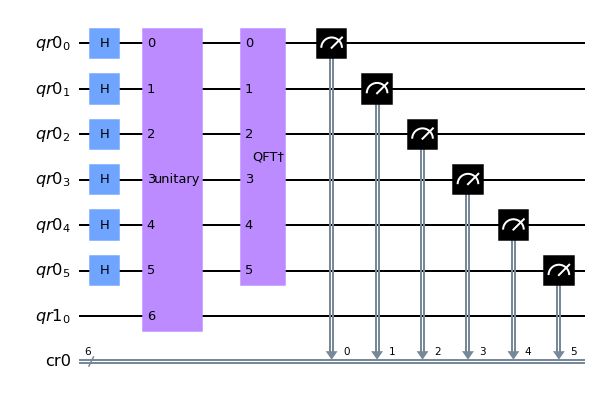

In [13]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
from utils import qft_dagger
nqubit = 6
nadd = 1
qc = QuantumCircuit(QuantumRegister(nqubit, 'qr0'), 
                    QuantumRegister(nadd,'qr1'),
                    ClassicalRegister(nqubit,'cr0'))


# Initialize counting qubits
# in state |+>
for q in range(nqubit):
    qc.h(q)

for i in range(nadd):
    qc.append(BooleanOracle(data,i),list(range(6))+[nqubit+i])

# for q in range(nqubit, nqubit+nadd):
#     qc.h(q)
    
qc.append(qft_dagger(nqubit), range(nqubit))

# # Measure circuit
qc.measure(range(nqubit),range(nqubit))
qc.draw('mpl')  # -1 means 'do not fold' 

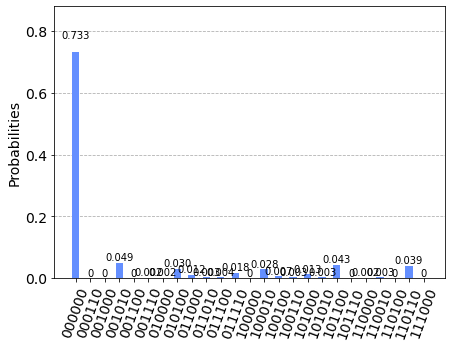

In [14]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)